# KL Divergence Penalty in RLHF

**Preventing reward hacking and maintaining stability**

## Why KL Penalty?

Without constraints, the policy can **drift** far from its initialization, leading to:

- **Reward hacking** — Exploiting reward model weaknesses
- **Mode collapse** — Generating repetitive outputs
- **Incoherent text** — Forgetting language patterns

The **KL divergence penalty** keeps the policy close to a frozen reference model.

## Mathematical Formulation

The total reward with KL penalty:

$$r_{\text{total}}(x, y) = r(x, y) - \beta \cdot D_{\text{KL}}(\pi_\theta(\cdot|x) \| \pi_{\text{ref}}(\cdot|x))$$

where:
- $r(x, y)$ = reward model score
- $\beta$ = KL coefficient (typically 0.1)
- $\pi_\theta$ = current policy
- $\pi_{\text{ref}}$ = frozen reference model

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_kl_penalty(
    logprobs: torch.Tensor,
    ref_logprobs: torch.Tensor,
    kl_coef: float = 0.1
) -> torch.Tensor:
    """
    Compute KL divergence penalty between policy and reference.
    
    KL(π || π_ref) ≈ E[log π - log π_ref]
    
    Args:
        logprobs: Log probs under current policy
        ref_logprobs: Log probs under reference model
        kl_coef: KL penalty coefficient (β)
    
    Returns:
        KL penalty scaled by coefficient
    """
    kl_divergence = logprobs - ref_logprobs
    kl_penalty = kl_coef * kl_divergence.mean()
    
    return kl_penalty

# Example
batch_size = 16
logprobs = torch.randn(batch_size) - 3.0
ref_logprobs = torch.randn(batch_size) - 3.0

kl_penalty = compute_kl_penalty(logprobs, ref_logprobs, kl_coef=0.1)
print(f"KL Penalty: {kl_penalty.item():.4f}")

KL Penalty: -0.0626


## Visualizing KL Penalty Effect

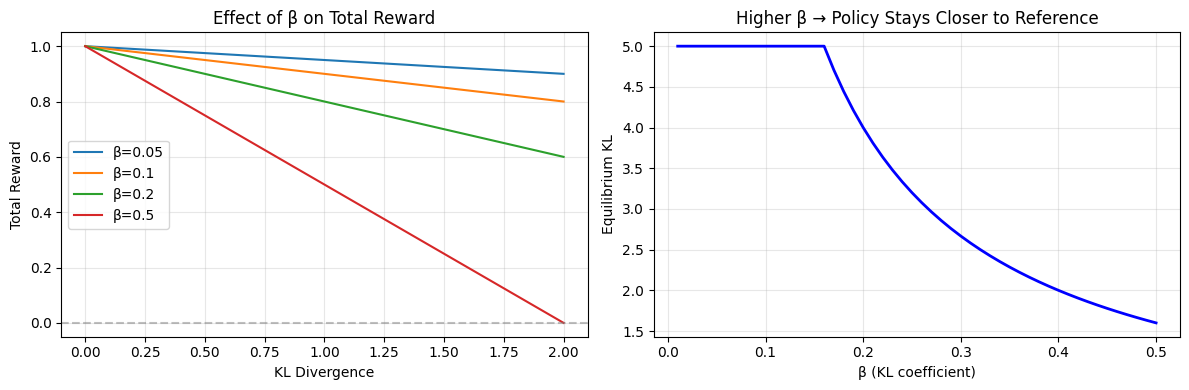

In [2]:
# Visualize how KL penalty affects total reward
kl_values = np.linspace(0, 2, 100)
base_reward = 1.0

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Different β values
for beta in [0.05, 0.1, 0.2, 0.5]:
    total_reward = base_reward - beta * kl_values
    axes[0].plot(kl_values, total_reward, label=f'β={beta}')

axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('KL Divergence')
axes[0].set_ylabel('Total Reward')
axes[0].set_title('Effect of β on Total Reward')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Optimal KL for different β
betas = np.linspace(0.01, 0.5, 50)
# Assuming policy wants to maximize reward - β*KL, 
# and reward increases with KL (reward hacking)
reward_gain_per_kl = 0.8
optimal_kl = reward_gain_per_kl / betas  # Where derivative = 0
optimal_kl = np.clip(optimal_kl, 0, 5)

axes[1].plot(betas, optimal_kl, 'b-', linewidth=2)
axes[1].set_xlabel('β (KL coefficient)')
axes[1].set_ylabel('Equilibrium KL')
axes[1].set_title('Higher β → Policy Stays Closer to Reference')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Applying KL in PPO

In [3]:
def compute_rewards_with_kl(
    rewards: torch.Tensor,
    policy_logprobs: torch.Tensor,
    ref_logprobs: torch.Tensor,
    kl_coef: float = 0.1
) -> torch.Tensor:
    """
    Compute total rewards with KL penalty subtracted.
    
    total_reward = reward - β * KL
    """
    # Per-token KL
    kl = policy_logprobs - ref_logprobs
    
    # Apply penalty
    total_rewards = rewards - kl_coef * kl
    
    return total_rewards, kl

# Example
rewards = torch.tensor([1.0, 0.5, -0.2, 0.8])
policy_logprobs = torch.tensor([-2.0, -2.5, -3.0, -2.2])
ref_logprobs = torch.tensor([-2.1, -2.3, -2.8, -2.5])

total_rewards, kl = compute_rewards_with_kl(rewards, policy_logprobs, ref_logprobs)

print("Original rewards:", rewards.tolist())
print("KL divergence:", kl.tolist())
print("Total rewards:", total_rewards.tolist())

Original rewards: [1.0, 0.5, -0.20000000298023224, 0.800000011920929]
KL divergence: [0.09999990463256836, -0.20000004768371582, -0.20000004768371582, 0.2999999523162842]
Total rewards: [0.9900000095367432, 0.5199999809265137, -0.17999999225139618, 0.7700000405311584]


## Tuning the KL Coefficient

| β Value | Effect |
|---------|--------|
| **Too low** (0.01) | Policy drifts, reward hacking |
| **Good** (0.1) | Balance between improvement and stability |
| **Too high** (1.0) | Policy can't improve, stuck near reference |

### Adaptive KL Control

Some implementations adjust β dynamically:
- If KL too high: increase β
- If KL too low: decrease β

In [4]:
class AdaptiveKLController:
    """Adaptive KL coefficient controller."""
    
    def __init__(self, init_kl_coef=0.1, target_kl=0.02, horizon=10000):
        self.kl_coef = init_kl_coef
        self.target_kl = target_kl
        self.horizon = horizon
    
    def update(self, observed_kl):
        """Update KL coefficient based on observed KL."""
        # Proportional control
        error = observed_kl - self.target_kl
        
        # Adjust coefficient
        if observed_kl > 1.5 * self.target_kl:
            self.kl_coef *= 1.5  # Increase penalty
        elif observed_kl < 0.5 * self.target_kl:
            self.kl_coef /= 1.5  # Decrease penalty
        
        # Clamp to reasonable range
        self.kl_coef = max(0.01, min(1.0, self.kl_coef))
        
        return self.kl_coef

# Example
controller = AdaptiveKLController(init_kl_coef=0.1, target_kl=0.02)

print("Adaptive KL Control:")
for observed_kl in [0.01, 0.02, 0.05, 0.1, 0.03, 0.02]:
    new_coef = controller.update(observed_kl)
    print(f"  Observed KL: {observed_kl:.3f} → β = {new_coef:.4f}")

Adaptive KL Control:
  Observed KL: 0.010 → β = 0.1000
  Observed KL: 0.020 → β = 0.1000
  Observed KL: 0.050 → β = 0.1500
  Observed KL: 0.100 → β = 0.2250
  Observed KL: 0.030 → β = 0.2250
  Observed KL: 0.020 → β = 0.2250


## Monitoring KL During Training

Track these KL-related metrics:

- **Mean KL**: Should stay in range [0.01, 0.1]
- **Max KL**: Watch for spikes indicating instability
- **KL over time**: Should stabilize, not diverge

## Next Steps

Now let's learn about the complete training dynamics — rollout generation, GAE, and the two-phase training loop.